In [1]:
%load_ext autoreload
%autoreload 2

# GenReco - The Lyrics-based Genre Recognizer

The primary objective of this project is to investigate the feasibility of predicting a song's genre based on its lyrical features. With the vast amount of music available today, categorizing songs into genres manually can be time-consuming and subjective.

By leveraging the power of data science techniques, we aim to explore whether the lyrical characteristics of songs can serve as reliable indicators for genre classification. Through this research, we intend to contribute to the field of music analysis and enhance our understanding of the relationship between lyrics and musical genres.

# Procedure

The project will follow a systematic procedure to investigate the predictability of song genres based on lyrical features.

## Study
Initially, extensive research will be conducted to gain a comprehensive understanding of the subject matter, exploring existing studies and theories related to music genre classification.

## Dataset Generation
To generate a suitable dataset for analysis, we will utilize the Spotify API to retrieve relevant song metadata such as artist, album, and genre information. Additionally, we will crawl lyrics from Genius.com, a popular lyrics website, to obtain the lyrical features necessary for our analysis. By combining these sources, we aim to create a diverse and representative dataset that encompasses a wide range of genres and artists.

## Pre-EDA
Once the dataset is obtained, we will focus on understanding its composition and characteristics.
 The characteristics we will be focusing on are the data types and their distributions.
 Exploratory data analysis (EDA) techniques, including visualizations and statistical summaries, will be employed to gain insights into the distribution and relationships between lyrical features and song genres. This exploratory phase will allow us to draw preliminary conclusions and identify any initial patterns or trends within the data, as well as measures of Central Tendency and Variability.

## Data Curation
Next, data curation steps will be applied to ensure the quality and reliability of the dataset. This process will involve the identification and removal of duplicate entries, as well as the detection and handling of outliers or inconsistencies in the data. By carefully curating the dataset, we aim to enhance the accuracy and integrity of our subsequent analysis.

## EDA
Following data curation, an in-depth exploratory data analysis will be conducted. This phase will involve examining the distributions, correlations, and other relevant statistical properties of the lyrical features across different genres. Visualizations such as histograms, scatter plots, and box plots will be employed to facilitate a comprehensive understanding of the dataset and unveil potential insights regarding the relationship between lyrical features and song genres.

## Machine Learning
With a solid grasp of the dataset and its characteristics, we will proceed to the model selection stage. Various machine learning algorithms, such as decision trees, random forests, or KNN, will be evaluated and compared to identify the most suitable model for genre prediction based on lyrical features. Model performance metrics, including accuracy, precision, and recall, will be assessed to determine the effectiveness of each algorithm in capturing the underlying patterns within the data.

## Conclusions
Finally, based on the chosen model and its performance, we will draw final conclusions regarding the project's main objective: the predictability of song genres using lyrical features. The findings of this research endeavor will shed light on the relationship between lyrics and musical genres, providing valuable insights for music analysis and potentially influencing future advancements in genre classification methodologies.

# Some Imports...
Here we are importing the 3rd-party libraries required for the notebook and demonstrations purposes,
as well as some proprietary functionality that we've exported to modules, in order to avoid clutter in the notebook.

In [2]:
# IMPORT 3RD PARTY LIBRARIES

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os.path as osp
import requests
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from langdetect import detect
import random
import re
from collections import Counter
import pandas as pd
import json
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.drop(label_column, axis=1),
        dataset[label_column],
        test_size=test_ratio,
        random_state=rand_state
    )

    return X_train, X_test, y_train, y_test


def get_classifier_obj(classifier_name, params):
    clf_map = {
        "KNN": KNeighborsClassifier,
        "naive_bayes": GaussianNB,
        "svm": SVC,
        "decision_tree": tree.DecisionTreeClassifier,
        "random_forest": RandomForestClassifier
    }

    params = params or {}
    return clf_map.get(classifier_name)(**params)


def calc_evaluation_val(eval_metric, y_test, y_predicted):
    metric_map = {
        'accuracy': metrics.accuracy_score,
        'precision': metrics.precision_score,
        'recall': metrics.recall_score,
        'f1': metrics.f1_score,
        'confusion_matrix': metrics.confusion_matrix
    }
    val = metric_map.get(eval_metric)
    if val is None:
        return
    kwargs = {}
    if eval_metric in ['precision', 'recall', 'f1']:
        kwargs['average'] = 'weighted'
    return val(y_true=y_test, y_pred=y_predicted, **kwargs)


def find_best_model(X_train, y_train, max_depth_val, min_samples_split_val):
    algos = {
        'svm': {},
        'naive_bayes': {},
        'decision_tree': {
            'max_depth': max_depth_val,
            'min_samples_split': min_samples_split_val
        }
    }
    best_recall = -1
    best_clf = None
    for algo in algos:
        clf = get_classifier_obj(algo, algos[algo])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        recall = calc_evaluation_val("recall", y_train, y_pred)
        if recall > best_recall:
            recall = best_recall
            best_clf = clf

    return best_clf, best_recall


def find_best_k_for_KNN(X_train, y_train):
    parameters = {'n_neighbors': [1,2,3,4,5,7,9,11,13,15,17,19]}
    clf = GridSearchCV(
        KNeighborsClassifier(),
        parameters,
        scoring=make_scorer(
            metrics.accuracy_score,
            greater_is_better=True
        )

    )

    clf.fit(X_train, y_train)
    return clf.best_params_.get('n_neighbors'), clf.best_score_

In [4]:
def remove_duplicates_and_drop_na(df: pd.DataFrame):
    clean_df = df.copy()
    clean_df.dropna(inplace=True)
    clean_df.drop_duplicates(["name", "artists"], inplace=True)

    return clean_df


def repair_numeric_missing_vals(df, numeric_cols):
    repaired_vals_map = {col: df[col].median() for col in numeric_cols}
    repaired_df = df.fillna(value=repaired_vals_map)

    return repaired_df


def my_dist_to_avg(col):
    z_score = (col - col.mean()) / col.std()
    col.loc[abs(z_score) > 3] = np.nan


def my_iqr(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    col.loc[(col < Q1 - 1.5 * IQR) | (col > Q3 + 1.5 * IQR)] = np.nan


def outlier_detection_iqr(df, dfunc):
    df_main = df.copy()
    [dfunc(df_main[col]) for col in df_main.select_dtypes('number')]

    return df_main


def transfer_to_categorical(df, bin_cols, categorical_col_names):
    transferred_df = df.copy()
    for col in bin_cols:
        transferred_df[f"{col}_categorical"] = pd.cut(
            transferred_df[col],
            5,
            labels=[1, 2, 3, 4, 5]
        )

    transferred_df = pd.get_dummies(
        data=transferred_df,
        columns=categorical_col_names,
        prefix=categorical_col_names
    )

    return transferred_df


In [5]:
def one_dim_plot(sr, plot_type, axis):
    if plot_type == 'bar':
        axis.bar(sr.index, sr.values)
    elif plot_type == 'pie':
        axis.pie(sr.values, labels=sr.index, autopct='%1.1f%%')
    elif plot_type == 'line':
        axis.plot(sr.index, sr.values, marker='o')
    else:
        print("Invalid plot type. Please choose 'bar', 'pie', or 'line'.")


def get_frequent_elements(df, col_name, num_top_elements):
    return df[col_name].value_counts().nlargest(num_top_elements).sort_index()


def plot_frequent_elements(df, df_params):
    fig, axs = plt.subplots(1, len(df_params), figsize=(20, 5))
    axs = np.array(axs).reshape(-1)
    for i, row in df_params.iterrows():
        col_name = row['col_name']
        plot_type = row['plot_type']
        num_top_elements = row['num_top_elements']
        sr = get_frequent_elements(df, col_name, num_top_elements)
        one_dim_plot(sr, plot_type, axs[i])
        axs[i].set_xlabel(col_name)
        axs[i].set_ylabel('Frequency')


def cross_tabulation(df, col_name, other_col_name):
    return pd.crosstab(df[col_name], df[other_col_name], normalize="index")


def plot_cross_tabulation(df, col_names, other_col_name):
    fig, axes = plt.subplots(1, len(col_names), figsize=(20, 5))
    for i, col_name in enumerate(col_names):
        one_dim_plot(cross_tabulation(df, col_name, other_col_name), "line", axes[i])
        axes[i].set_xlabel(col_name)
        axes[i].set_ylabel(other_col_name)


def get_highly_correlated_cols(df):
    corr = df.select_dtypes("number", "category").corr()
    n = corr.shape[0]
    correlated_cols = []
    for i in range(n):
        for j in range(i + 1, n):
            if abs(corr.iloc[i, j]) >= 0.5:
                correlated_cols.append((i, j))
    correlations = [corr.iloc[i, j] for i, j in correlated_cols]
    return correlations, correlated_cols


def plot_high_correlated_scatters(df):
    _, tuple_arr = get_highly_correlated_cols(df)

    fig, axes = plt.subplots(nrows=1, ncols=len(tuple_arr))

    for i, (col1, col2) in enumerate(tuple_arr):
        axes[i].scatter(df.iloc[:, col1], df.iloc[:, col2])
        corr_val = df.iloc[:, [col1, col2]].corr().iloc[0, 1]
        title = f"corr('{df.columns[col1]}', '{df.columns[col2]}')={corr_val:4.2f}"
        axes[i].set_title(title)


def transfer_str_to_numeric_vals(dataset):
    # Transfer dataset's values to numeric ones
    for column in dataset.columns:
        labels = dataset[column].astype("category").cat.categories.to_list()
        lab_map = {value: index for index, value in enumerate(labels)}
        dataset[column] = dataset[column].map(lab_map)

    return dataset


def plot_frequencies(dataset, cols, plot_type, num_top=None):
    cols_cnt = min(len(cols), 3)
    rows_cnt = math.ceil((len(cols) / 3))

    for dummy in range(rows_cnt):
        sub_list = cols[dummy * cols_cnt:(dummy + 1) * cols_cnt]
        plot_frequent_elements(
            dataset,
            pd.DataFrame({
                'plot_type': [plot_type] * len(sub_list),
                'col_name': sub_list,
                'num_top_elements': [num_top or 10000] * len(sub_list)
            })
        )


def plot_histograms(dataset, cols):
    cols_cnt = min(len(cols), 3)
    rows_cnt = math.ceil((len(cols) / 3))

    for ridx in range(rows_cnt):
        fig, axs = plt.subplots(1, min(cols_cnt, len(cols) - ridx * 3), figsize=(20, 5))
        axs = np.array(axs).reshape(-1)
        for i, col in enumerate(cols[ridx * 3:ridx * 3 + 3]):
            sns.histplot(dataset[col], ax=axs[i])


def plot_continuous_feature_relations(dataset, continuous_vars):
    var_combinations = [(var1, var2) for var1 in continuous_vars for var2 in continuous_vars if var1 < var2]
    rows_num = math.ceil(len(var_combinations) / 3)
    for row_index in range(rows_num):
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))
        axs = axs.flatten()
        for index, feature in enumerate(var_combinations[3 * row_index:3 * row_index + 3]):
            sns.scatterplot(dataset, x=feature[0], y=feature[1], ax=axs[index % 3])

In [6]:
GENRE_LIST = [
    'pop', 'rock', 'hip-hop', 'rap', 'r&b', 'soul', 'electronic', 'dance', 'country', 'jazz', 'classical',
    'reggae', 'alternative', 'indie', 'folk', 'metal', 'punk', 'blues', 'world', 'funk', 'disco', 'gospel'
]


def fix_genre(genre_string):
    mapping = {
        'canadian hip hop': 'hip-hop',
        'lgbtq+ hip hop': 'hip-hop',
        'hip hop': 'hip-hop',
        'hip pop': 'hip-hop',
        "metalcore": "metal",
        "k-pop": "pop",
    }
    # Return genre mapped genre if matched
    if genre_string.lower() in mapping.keys():
        return mapping.get(genre_string)

    # If got here genre is not recognized, will not be counted
    return genre_string


def split_list_items(list_items):
    merged_list = [item.split() for item in list_items]
    flattened_list = [word for sublist in merged_list for word in sublist]
    return flattened_list


def remove_non_genres(word_list):
    # Search weired genre patterns for each genre in genre list
    # Returns actual genre list
    # Avoid counting trap as rap
    return [genre for genre in GENRE_LIST for item in word_list if genre in item and item != 'trap']


def get_common_genre(song_genres):
    dash_removed = [item.replace("-", " ") for item in song_genres]
    split_list = [item.partition("hip hop") for item in dash_removed]
    flatten = [subitem for item in split_list for subitem in item if subitem]
    fixed_list = [fix_genre(item) for item in flatten]
    new_list = split_list_items(fixed_list)
    clean_list = remove_non_genres(new_list)
    if not clean_list:
        return

    genre_counts = Counter(clean_list)  # dict
    elements = [element for element, freq in genre_counts.items()]
    freqs = [freq for element, freq in genre_counts.items()]
    # Choose randomly between the known genres!
    return random.choices(elements,freqs)[0]


def purify_text(text):
    # Make replace table
    trans_table = str.maketrans({'&': 'and', 'é': 'e'})
    text = text.translate(trans_table)
    # Remove anything inside parentheses (including parentheses)
    text = re.sub(r'\([^)]*\)', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    # Replace spaces with dash
    text = re.sub(r'\s', '-', text)

    return text.lower()


def remove_file(file_path):
    try:
        os.remove(file_path)
        print("File removed successfully")
    except OSError as e:
        pass


def save_dataset(data, filepath, overwrite=False):
    # Convert raw data into pandas df for an easier save
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    if overwrite or not os.path.exists(filepath):
        # write mode by default, overwrites csv data
        data.to_csv(filepath, index=False)

    else:
        # Append to an existing csv file, ignore header
        data.to_csv(filepath, index=False, mode="a", header=False)

    print(f"Data successfully saved as '{filepath}'.")


def load_dataset(filepath):
    return pd.read_csv(filepath)


def is_file_valid(file_path):
    if os.path.exists(file_path):
        file_size = os.stat(file_path).st_size
        return file_size > 0
    return False


In [7]:
slang_file_path = 'utils/slang_words.txt'

STOPWORD_LIST = set(stopwords.words('english'))
SLANG_WORDS = []
with open(slang_file_path, 'r') as file:
    [SLANG_WORDS.append(line.strip()) for line in file]


class LyricsHandler:
    def __init__(self, lyrics_file):
        if not is_file_valid(lyrics_file):
            raise FileNotFoundError

        self.lyrics_raw = self.load_song_lyrics(lyrics_file)
        self.lyrics_lines = [line for line in self.lyrics_raw.split("\n") if line]
        self.clean_lyrics = self.clean_lyrics_string(" ".join(self.lyrics_lines))
        self.tokenized_lyrics = self.clean_lyrics.split()

    @staticmethod
    def load_song_lyrics(text_file):
        with open(text_file, 'r') as tf:
            string = tf.read()
        return string.lower()

    @staticmethod
    def clean_lyrics_string(string):
        string = re.sub(r'-', ' ', string)
        # Allow only letters, but remove anything inside a [] before to get rid of vers/chorus/singer names
        return re.sub(r'[^a-zA-Z\s\']', '', re.sub(r'\[.*?\]', '', string))

    @staticmethod
    def is_slang_word(word):
        return word.endswith("'") or word.startswith("'") or word.replace("'", "") in SLANG_WORDS

    @staticmethod
    def is_stop_word(word):
        return word.lower() in STOPWORD_LIST

    def intro_outro_vers_chorus_cnt(self):
        section_prefixes = ["intro", "outro", "verse", "chorus"]
        cnt_dict = {f"{prefix}_cnt": 0 for prefix in section_prefixes}
        for line in self.lyrics_lines:
            for prefix in section_prefixes:
                if f"[{prefix}" in line:
                    cnt_dict[f"{prefix}_cnt"] += 1
                    break

        return cnt_dict

    def count_words_by_type(self, word_type, unique=False):
        if word_type == "slang":
            return self.count_special_words(self.is_slang_word, unique)
        if word_type == "stop":
            return self.count_special_words(self.is_stop_word, unique)
        if word_type == "all":
            return len(self.clean_lyrics.split(" ")) if not unique else len(set(self.clean_lyrics.split(" ")))

    def count_special_words(self, detect_func, unique):
        word_list = self.tokenized_lyrics if not unique else set(self.tokenized_lyrics)
        # return [word for word in word_list if detect_func(word)]
        return sum(1 for word in word_list if detect_func(word))

    def sentiment_analysis(self):
        sid = SentimentIntensityAnalyzer()
        sentiment = sid.polarity_scores(self.clean_lyrics)
        return sentiment

    def extract_lyrics_features(self):
        word_count = self.count_words_by_type("all")
        unique_words = self.count_words_by_type("all", unique=True)
        stopword_count = self.count_words_by_type("stop")
        slang_word_count = self.count_words_by_type("slang")
        cnt_dict = self.intro_outro_vers_chorus_cnt()
        sentiment = self.sentiment_analysis()

        features = {
            **cnt_dict,
            "line_cnt": len(self.lyrics_lines),
            "word_cnt": word_count,
            "unique_word_cnt": unique_words,
            "stop_word_cnt": stopword_count,
            "slang_word_cnt": slang_word_count,
            "positive": sentiment.get("pos"),
            "negative": sentiment.get("neg"),
            "neutral": sentiment.get("neu"),
            "compound": sentiment.get("compound"),
        }
        return features


def fetch_lyrics(url):
    # Format the artist and song title for the URL
    print(f"Fetching: {url}")
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        print("I got something")
        # Use BeautifulSoup to parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the lyrics section
        lyrics_divs = soup.find_all('div', attrs={"data-lyrics-container": "true"})
        lyrics_lines = []
        for d in lyrics_divs:
            [lb.replaceWith('\n') for lb in d.findAll('br')]

            lines = re.sub('\n{2,}', '\n', d.getText().strip())
            lyrics_lines.append(lines)

        return lyrics_lines

    print(f"Lyrics data not found")
    # Return None if lyrics couldn't be fetched
    return None


def save_lyrics(txt, file_path):
    with open(file_path, 'w') as file:
        file.write(txt)


def get_lyrics_and_save(genius_url, lyrics_file):
    lyrics = fetch_lyrics(genius_url)
    if not lyrics:
        print("RETURNS PARTIAL DATA DUE TO LYRICS FETCH FAILURE")
        return

    save_lyrics('\n'.join(lyrics), lyrics_file)

    print(f"INIT HANDLER FOR FILE: {lyrics_file}")
    lyrics_handler = LyricsHandler(lyrics_file)
    lyrics_features = lyrics_handler.extract_lyrics_features()
    return lyrics_features


def reget_lyrics_df(dataset):
    for index, row in dataset.iterrows():
        record = row.copy()
        f = get_lyrics_and_save(record.lyrics_url, record.lyrics_file)
        record.update(f)
        dataset.loc[index] = record

    return dataset


def is_english_song(row):
    handler = LyricsHandler(row["lyrics_file"])
    lyrics = handler.clean_lyrics
    try:
        language = detect(lyrics)
    except:
        return False

    return language == "en"


def remove_non_english_songs(df):
    return df[df.apply(is_english_song, axis=1)]


In [8]:
with open('utils/creds.json', 'r') as fp:
    creds_dict = json.load(fp)

spotify = spotipy.Spotify(
    client_credentials_manager=SpotifyClientCredentials(**creds_dict)
)


def fetch_tracks(search_query=None, limit=10, offset=0):
    if search_query is None:
        search_query = ""
    print(f"SEARCH QUERY: {search_query}")
    response = spotify.search(search_query, limit=limit, offset=offset, type="track")
    return response.get("tracks", {}).get("items", [])


def fetch_track_data(track_obj):
    try:
        track_data = extract_tracks_data(track_obj, audio_features=False)
        purified_artists = purify_text(track_data.get('artists'))
        purified_name = purify_text(track_data.get('name'))
        genius_url = f"https://genius.com/{purified_artists}-{purified_name}-lyrics"
        lyrics_file = os.path.join("song_lyrics", f"{purified_artists}-{purified_name}.txt")
        track_data["lyrics_file"] = lyrics_file
        track_data["lyrics_url"] = genius_url
        if not is_file_valid(lyrics_file):
            print("LYRICS FILE IS NOT FOUND OR NOT VALID")
            lyrics = fetch_lyrics(genius_url)
            if not lyrics:
                print("RETURNS PARTIAL DATA DUE TO LYRICS FETCH FAILURE")
                return track_data

            save_lyrics(''.join(lyrics), lyrics_file)

        print(f"INIT HANDLER FOR FILE: {lyrics_file}")
        lyrics_handler = LyricsHandler(lyrics_file)
        lyrics_features = lyrics_handler.extract_lyrics_features()
        print(f"EXTRACTED FEATURES:\n{lyrics_features}")
        track_data.update(lyrics_features)

        return track_data

    except Exception as err:
        print(f"FAILED FETCH TRACK DATA: {err}")


def extract_tracks_data(track, audio_features=False):
    print(f"EXTRACTING TRACK FEATURES, AUDIO FEATURES = {audio_features}")
    artists = track.get("artists", [])[0]
    artist_id = artists.get("id")
    artist_info = spotify.artist(artist_id)
    artist_genres = artist_info.get("genres", [])
    release_date = track.get("album", {}).get("release_date")

    track_dict = {
        "name": str(track.get("name")),
        "artists": str(artist_info.get("name")),
        "release_year": int(release_date.split("-")[0]),
        "release_month": int(release_date.split("-")[1]) if "-" in release_date else None,
        "genres": list(artist_genres),
        "common_genre": get_common_genre(artist_genres),
        "duration": int(track.get("duration_ms")),
        "popularity": int(track.get("popularity"))
    }

    if audio_features:
        track_audio_features = spotify.audio_features(track.get("uri"))[0]
        track_dict.update(**{key: float(track_audio_features.get(key)) for key in
                             ["danceability", "energy", "key", "loudness", "speechiness", "acousticness",
                              "instrumentalness",
                              "liveness", "valence", "tempo"]})

    return track_dict

In [9]:
def generate_dataset():
    for offset in range(offset_range):
        limit = min(50, song_per_genre - 50 * (offset + 5))
        for genre in GENRE_LIST:
            try:
                dataset = []
                print(f"\nFETCHING {song_per_genre} {genre.upper()} SONGS, LIMIT: {limit}")
                res = fetch_tracks(query + f" genre:{genre}", limit=limit, offset=offset * 50)
                if not res:
                    print(f"FAILED TO FETCH {genre.upper()} SONGS")
                    continue

                for index, track in enumerate(res):
                    print(f"\nPARSING SONG DATA ({index + 1})")
                    data = {"source_genre": genre}
                    track_data = fetch_track_data(track)
                    data.update(track_data)
                    dataset.append(data)
                    print(f"SONG DATA SAVED")

                save_dataset(dataset, dataset_file_path, False)

            except Exception as e:
                print(f"FAILED FETCHING TRACKS: {e}")


if __name__ == '__main__':
    query = "year:1980-2023"
    file_name = "huge_dataset.csv"
    song_per_genre = 1000
    offset_range = int(song_per_genre / 50) or 1
    print(f"GOING TO FETCH {song_per_genre * len(GENRE_LIST)} TRACKS")
    # dataset_file_path = osp.join(osp.dirname(osp.abspath(__file__)), file_name)
    # generate_dataset()

    # RECALCULATE IF NEEDED
    # df = load_dataset(dataset_file_path)
    # recalculate_dataset(df)
    # save_dataset(df, dataset_file_path, True)

GOING TO FETCH 22000 TRACKS


# Dataset Generation

The generation of the dataset was carried out separately using a regular Python script execution. This approach was chosen to maintain a clear distinction between the dataset and its analysis within this notebook. By treating the dataset as pre-existing data, it allows for better organization of our thought process and prevents mixing the data generation process with its subsequent analysis.

>Having said that, during the process of the data analysis, we will not shy away from manipulating the data to fit our needs.

<i>Refer to generate_dataset.py</i>

# Loading the Dataset

In [10]:
file_name = "huge_dataset.csv"
dataset_file_path = osp.join(osp.dirname(osp.abspath("__file__")), file_name)
dataset = load_dataset(dataset_file_path)

# Pre-EDA: Data Visualization

Let us examine the individual columns in the data.
The data contains the following fields:

| Column Name      | Data Type   | Variable type |
|------------------|-------------|----|
| source_genre     | object      | Free text |
| name             | object      | Free text |
| artists          | object      | Free text |
| release_year     | int64       | Ordinal |
| release_month    | float64     | Ordinal |
| genres           | object      | List |
| genre     | object      | Categorial |
| duration         | int64       | Numeric|
| popularity       | int64       | Ordinal|
| lyrics_file      | object      | Free text (metadata) |
| lyrics_url       | object      | Free text (metadata) |
| intro_cnt        | float64     | Ordinal|
| outro_cnt        | float64     | Ordinal|
| verse_cnt        | float64     | Ordinal|
| chorus_cnt       | float64     | Ordinal|
| line_cnt         | float64     | Numeric|
| word_cnt         | float64     | Numeric|
| unique_words_cnt | float64     | Ordinal |
| stop_words_cnt   | float64     | Ordinal |
| slang_words_cnt  | float64     | Ordinal |
| positive         | float64     | Ordinal |
| negative         | float64     | Ordinal |
| neutral          | float64     | Ordinal |
| compound         | float64     | Ordinal |

## Top Elements
With Pie Charts, we can see the ratio of the leading elements of each feature

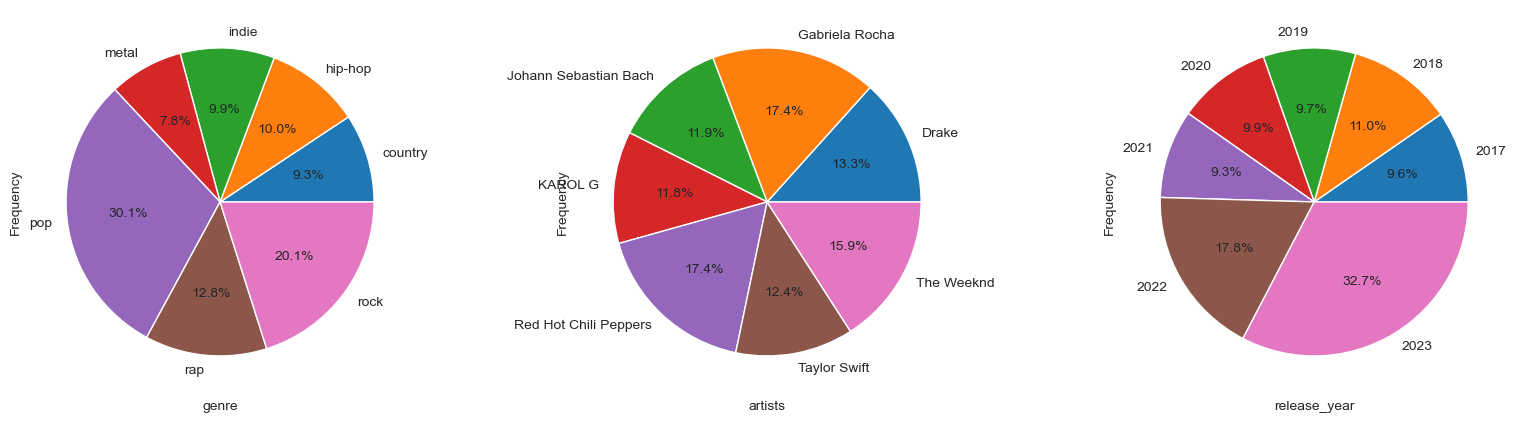

In [11]:
pie_cols = ['genre', 'artists', 'release_year']
plot_frequencies(dataset, pie_cols, 'pie', 7)

As the graphs show, we can learn that, out of the leading values:
- there are significantly more pop songs than other genres
- the artists are mostly balanced
- big majority of the data is recently released songs

## Ordinal Variables Frequency
With Bar Charts, it's easier to understand how frequent every ordinal variable is, in relation to itself.
We are using bar charts as the data has relatively small diversity in data (less values, more repetitions)

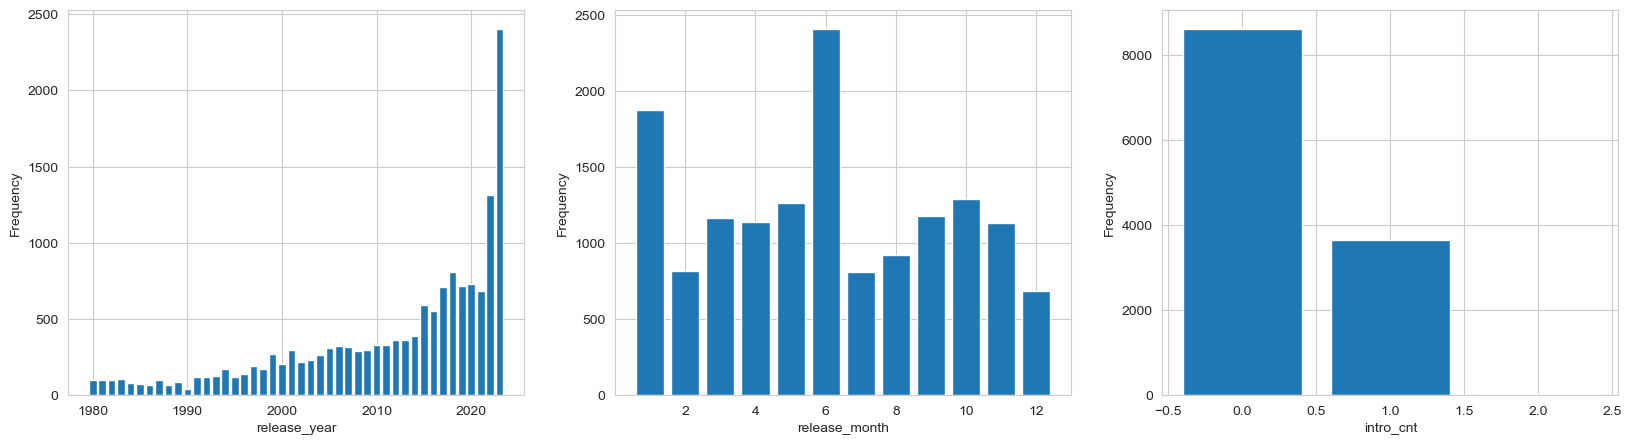

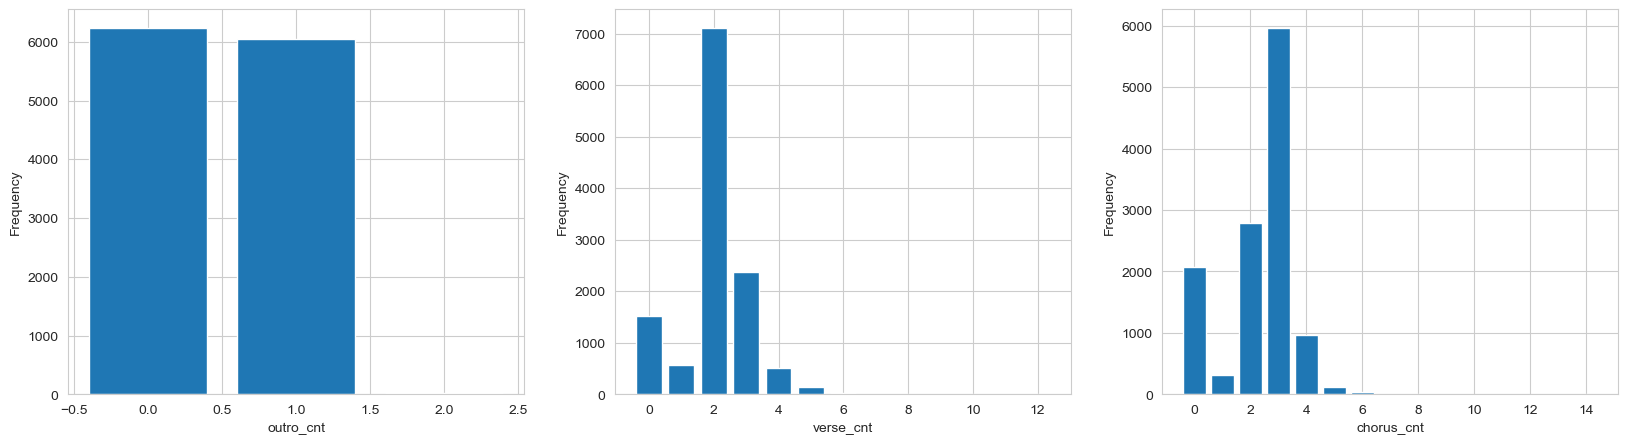

In [12]:
bars_cols = ['release_year', 'release_month',
             'intro_cnt', 'outro_cnt', 'verse_cnt', 'chorus_cnt']
plot_frequencies(dataset, bars_cols, 'bar')

As the graphs show, we can learn that:
- as seen before, most of the data is indeed new songs. In addition, the data decreases as the years go back
- <b>suspiciously</b>, there are 0 chorus and verse count, which might indicate an issue with the data
- songs are release relatively on the same rate across the year's month, with a slight increase at the beginning and middle of the year (summer and winter peaks)

## Continuous Variable Distributions
For variables which values are continuous we'll use histogram charts to show their distributions

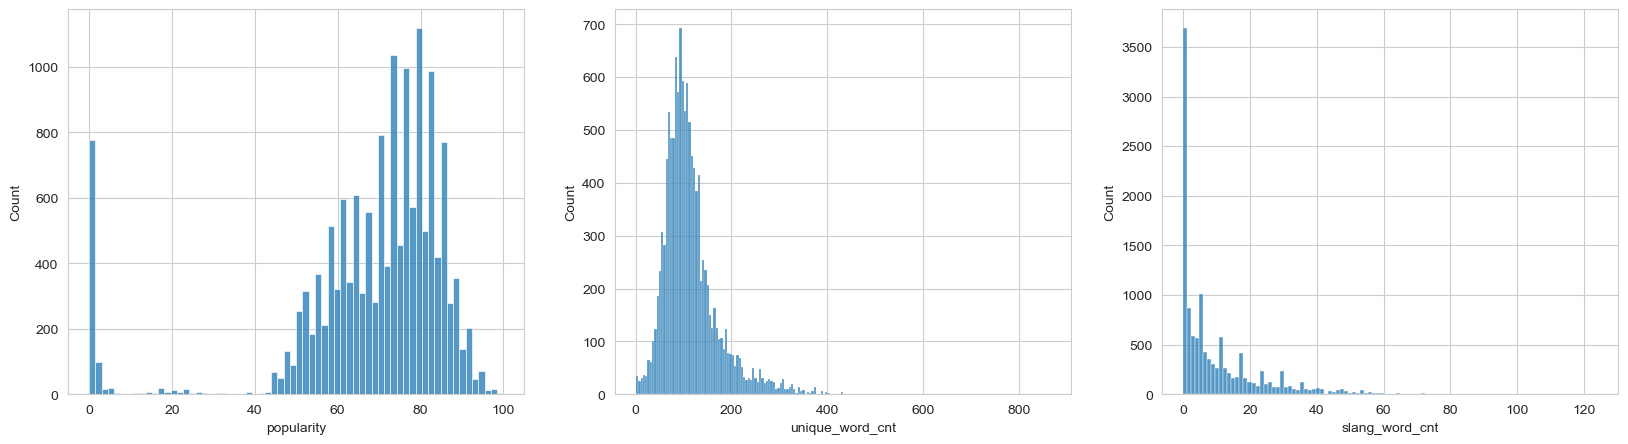

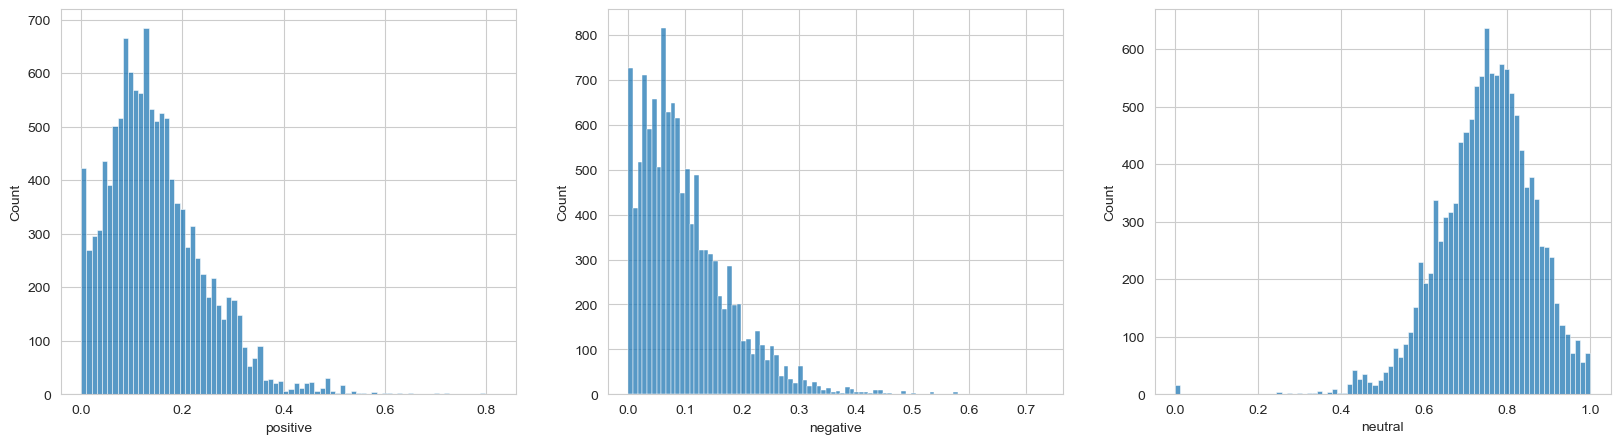

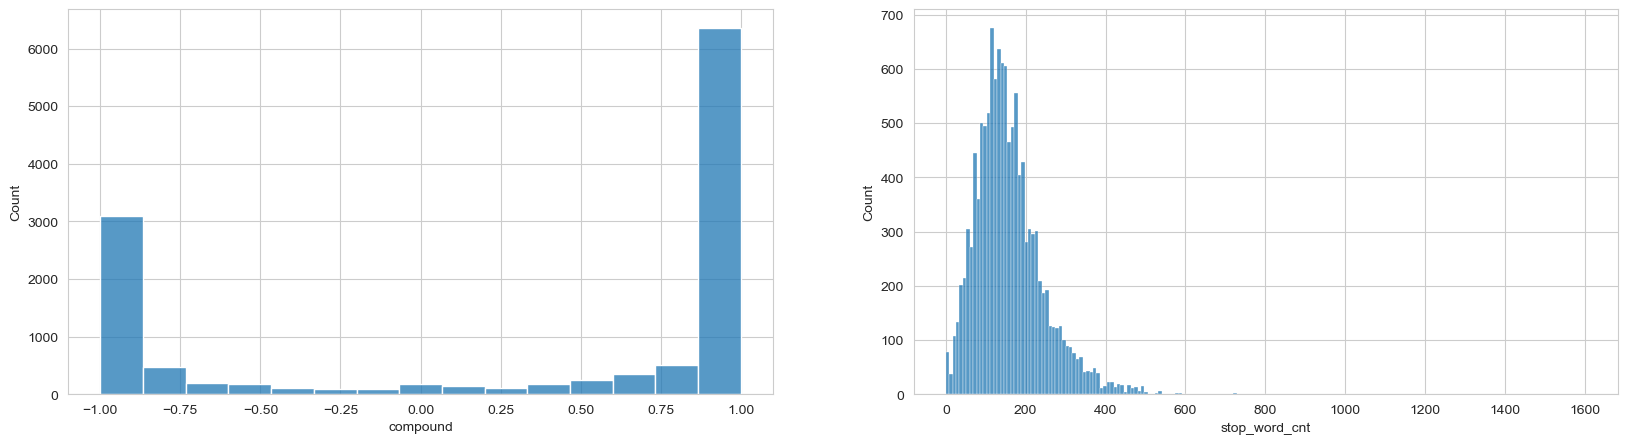

In [13]:
histogram_cols = ['popularity', 'unique_word_cnt', 'slang_word_cnt',
                  'positive', 'negative', 'neutral', 'compound', 'stop_word_cnt']
plot_histograms(dataset, histogram_cols)

As the graphs show, we can learn that:
- popularity has lots of 0's, which are missing values - so this column should probably be disregarded

# Follow-up suspicions
1. Zero chorus/verse count
    - we found out many songs had no lyrics files attached in the dataset, and most of them were from classical genre.
        This makes sense as the classical music is instrumental. Hence, we will discard the classic genre
    - another cause for the missing data about chorus/verse was songs in foreign language, where the chorus was labeled in the native language, rather English). We will discard foreign songs from the dataset
    - finally, the remaining missing data was due to wrong format of the lyrics file, which had no labels as we expected. This data is kept and these records will be handled by filling the missing values with the mean, to keep balance.
2. Zero popularity
    - As opposed to our initial assumption, that records where popularity was 0 are very old songs, we were surprised to find out that ALL the 0-popularity songs are from June 2023 (as shown in the graph below)
        We assume this is caused by either lack of data on the Spotify database or that they try to give chance for new release to gain popularity.
        We decided to keep the popularity as the missing values are at low freq (less than 8%), and we will fill them with the mean.

<Axes: xlabel='release_year', ylabel='popularity'>

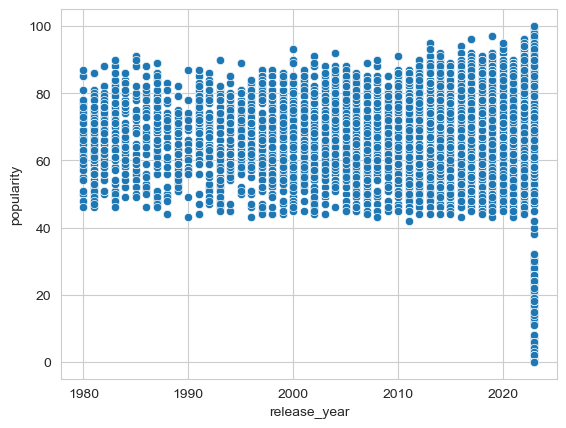

In [14]:
sns.scatterplot(dataset, y="popularity", x="release_year")

# Feature Relations Visualizations
Let's examine the relationships between our features, in pairs. For that we'll use Scatterplot of each pair.

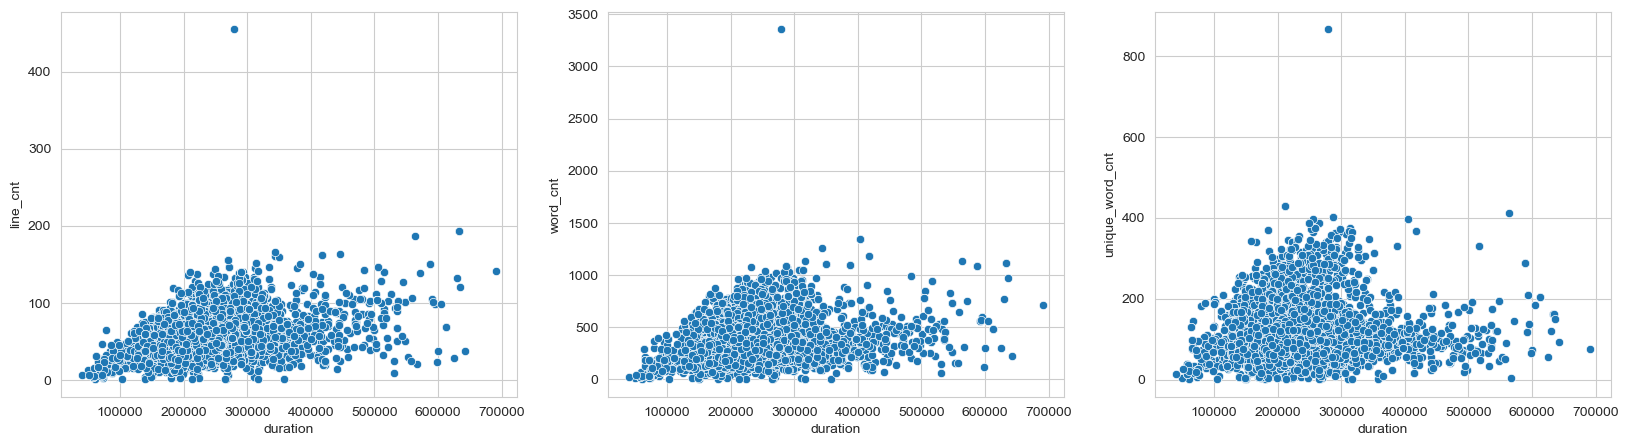

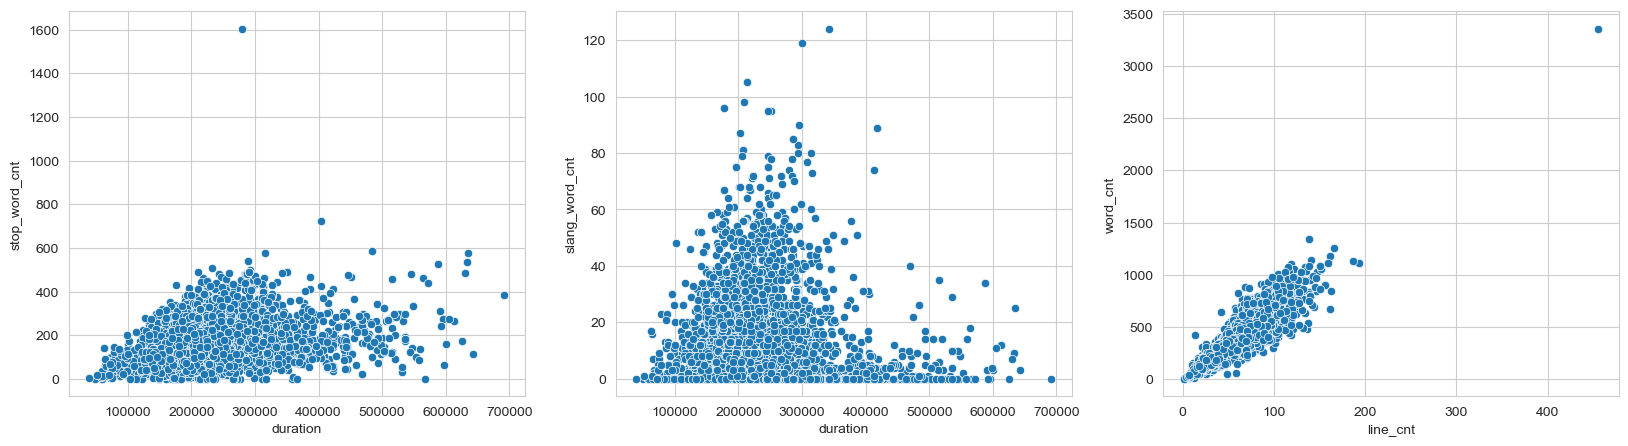

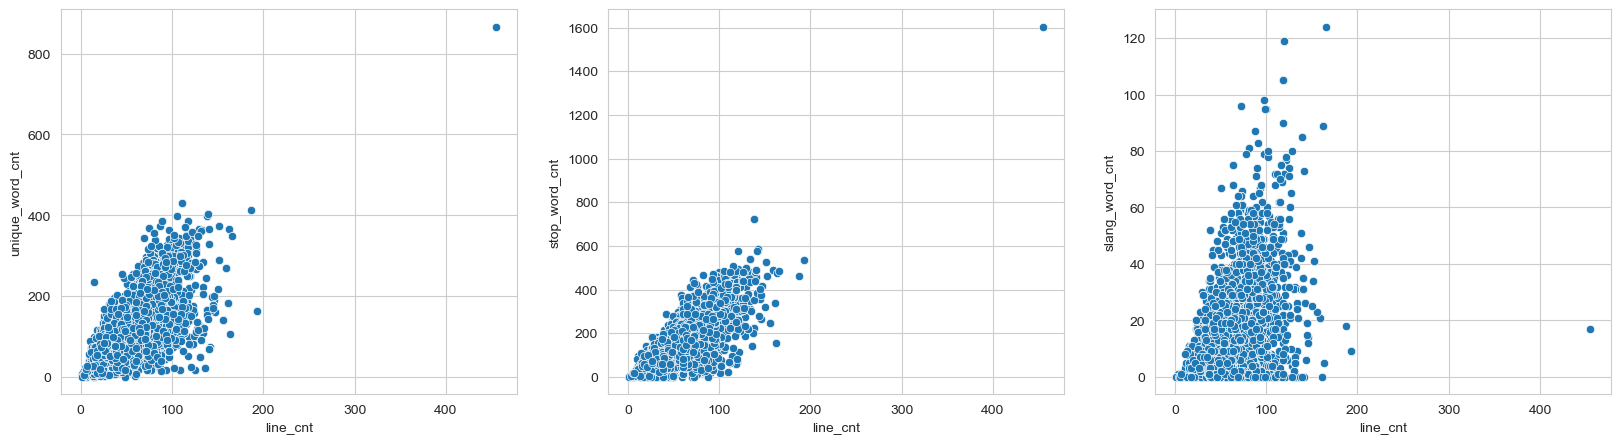

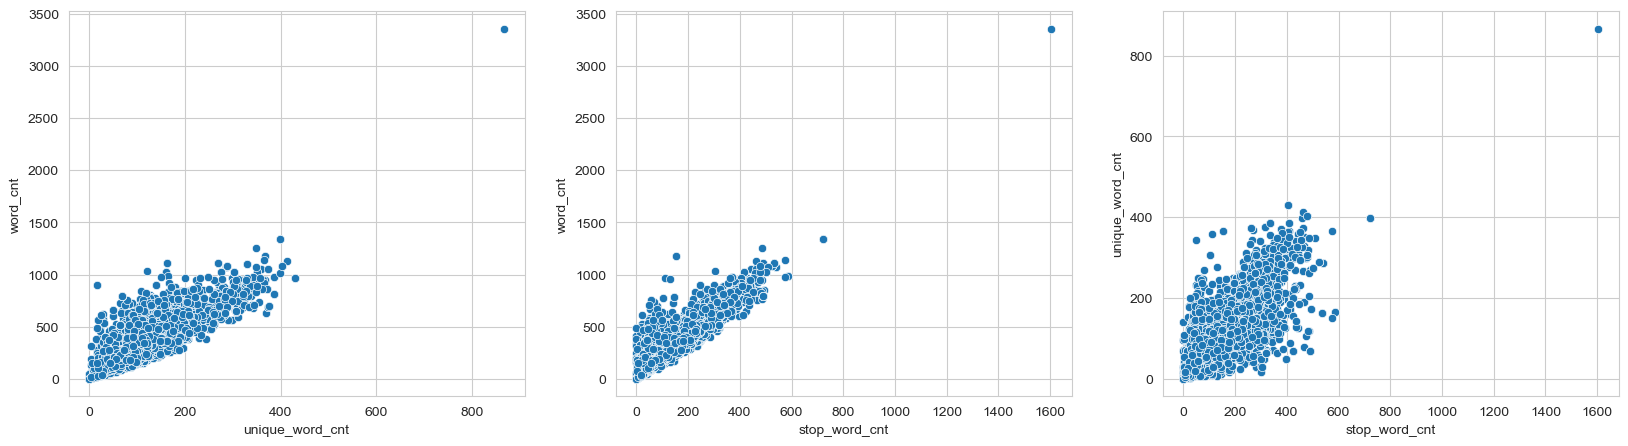

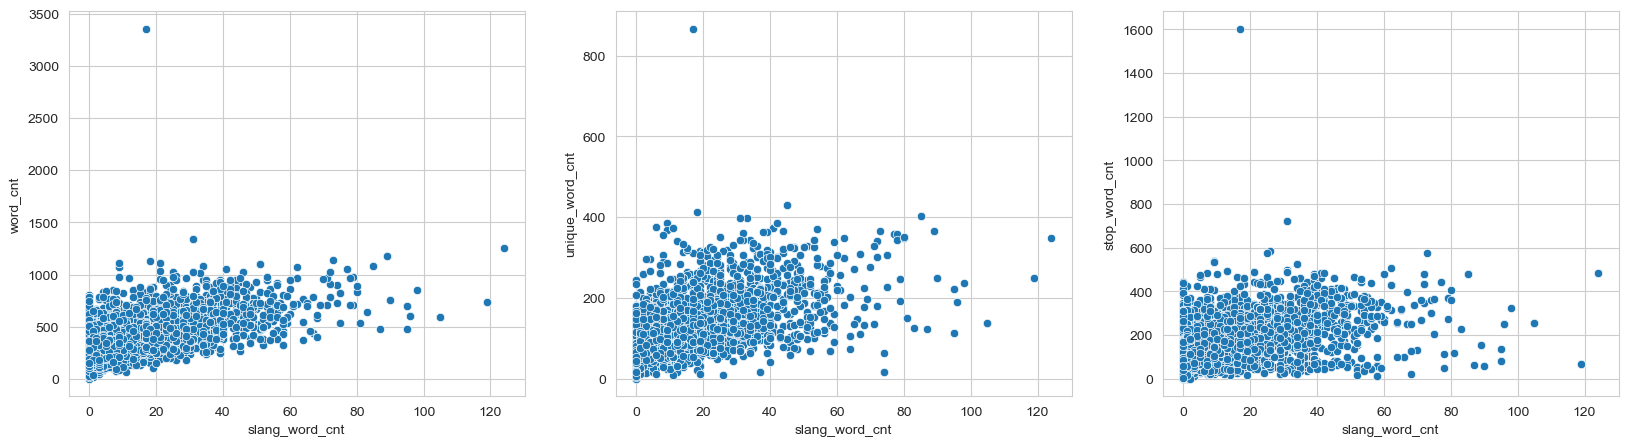

In [15]:
continuous_vars = ["duration", "line_cnt", "word_cnt", "unique_word_cnt", "stop_word_cnt", "slang_word_cnt"]
plot_continuous_feature_relations(dataset, continuous_vars)

## Relationships Insights
Except for the obvious increase in count feature to the word or line count features, there doesn't seem to be any distinct relationship we can conclude from the data

# Data Curation

## Missing Values & Outliers Hunt
As identified above, we have some records we want to discard due to invalidity.
Here we will remove the classic genre, and non-English songs. Then, we will fill the remaining missing values with the mean of each column respectively.

Seeing the graphs have less dense areas, we identify there are some few values that are outliers relative to the majority of the data. We would like to discard them to get a consolidated data

<BarContainer object of 15 artists>

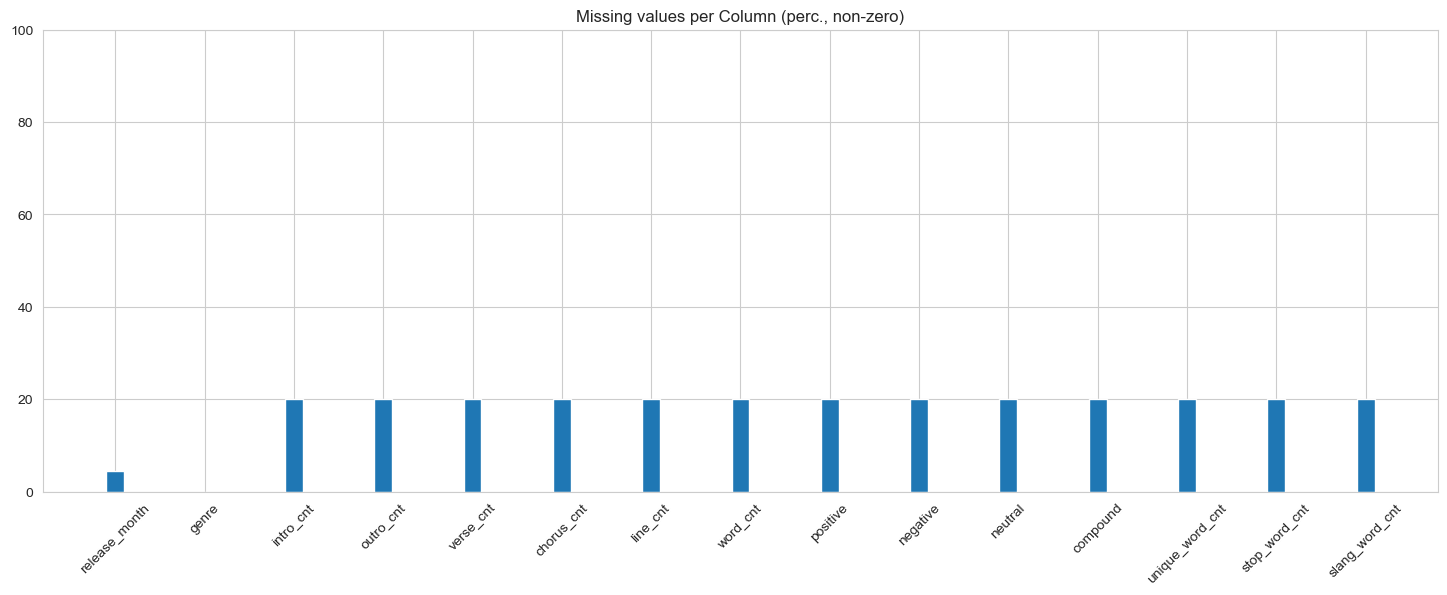

In [16]:
missing_values = (dataset.isna() | dataset.isnull()).sum() / len(dataset)
missing_values = missing_values[missing_values>0]
plt.figure(figsize=(18, 6))
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.title("Missing values per Column (perc., non-zero)")
plt.bar(missing_values.index, missing_values.values*100, width=0.2)

## Analysis: missing values
Some records don't have the release_month field set. This is because the original released date in the dataset included the release year only. Since this is a not-so-significant amount of data, we will get rid of these lines

In [17]:
dup_na_removed = remove_duplicates_and_drop_na(dataset)
non_english_removed = remove_non_english_songs(dup_na_removed)
outliers = outlier_detection_iqr(non_english_removed, my_dist_to_avg)
repaired = repair_numeric_missing_vals(outliers, dup_na_removed.select_dtypes('number'))
# Fix cnt values to be int
for col in repaired.columns:
    if "_cnt" in col or col in ['duration', 'popularity', 'release_year', 'release_month']:
        repaired[col] = repaired[col].astype(int)

repaired.drop(repaired[repaired.genre == 'classical'].index, inplace=True)
repaired.genre = repaired.genre.astype('category')
repaired.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5034 entries, 0 to 15397
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   source_genre     5034 non-null   object  
 1   name             5034 non-null   object  
 2   artists          5034 non-null   object  
 3   release_year     5034 non-null   int64   
 4   release_month    5034 non-null   int64   
 5   genres           5034 non-null   object  
 6   genre            5034 non-null   category
 7   duration         5034 non-null   int64   
 8   popularity       5034 non-null   int64   
 9   lyrics_file      5034 non-null   object  
 10  lyrics_url       5034 non-null   object  
 11  intro_cnt        5034 non-null   int64   
 12  outro_cnt        5034 non-null   int64   
 13  verse_cnt        5034 non-null   int64   
 14  chorus_cnt       5034 non-null   int64   
 15  line_cnt         5034 non-null   int64   
 16  word_cnt         5034 non-null   int64   

/var/folders/nn/xx0mvlls6ts9cz3280r610dw0000gp/T/ipykernel_40225/2699102477.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col.loc[abs(z_score) > 3] = np.nan


## Visualize - Round #2
Let's inspect the data after curation. We expect all the graphs to be dense and the data will remain balanced

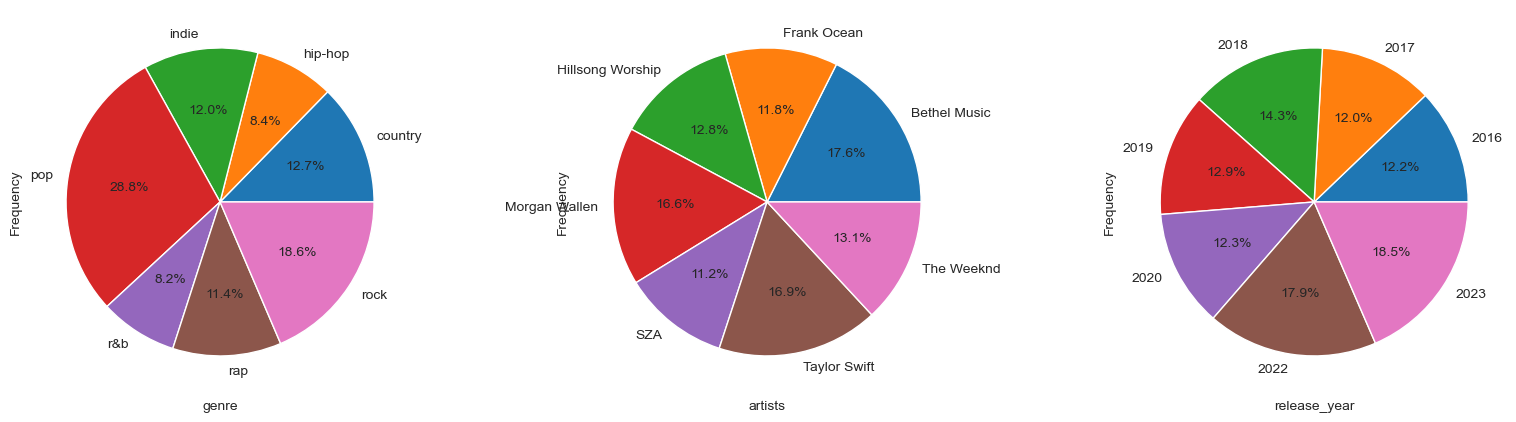

In [18]:
pie_cols = ['genre', 'artists', 'release_year']
plot_frequencies(repaired, pie_cols, 'pie', 7)

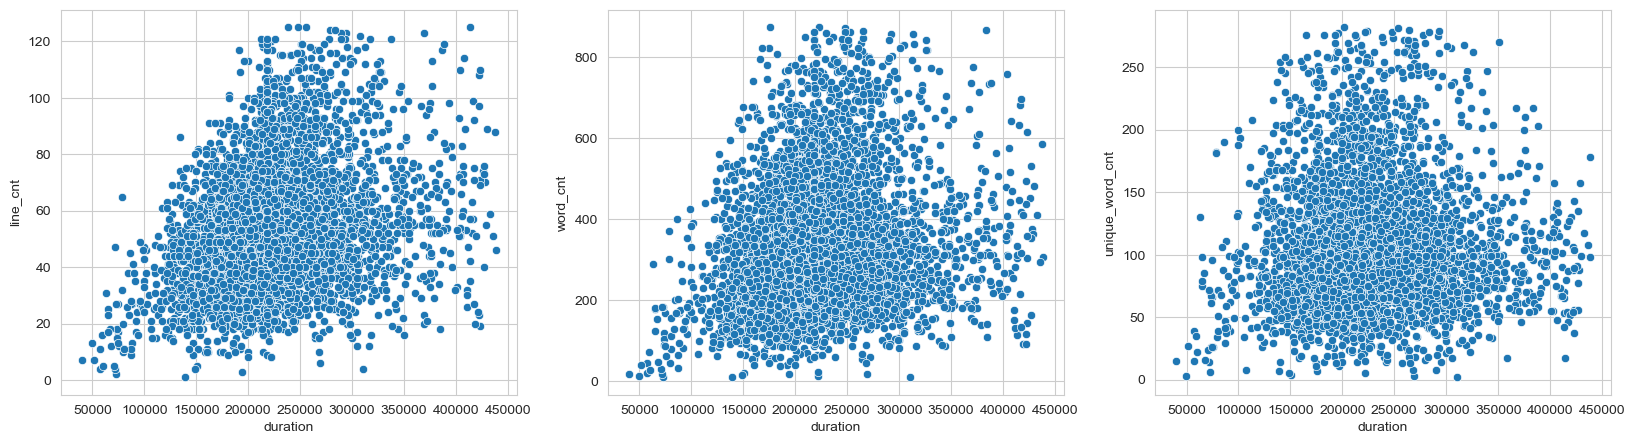

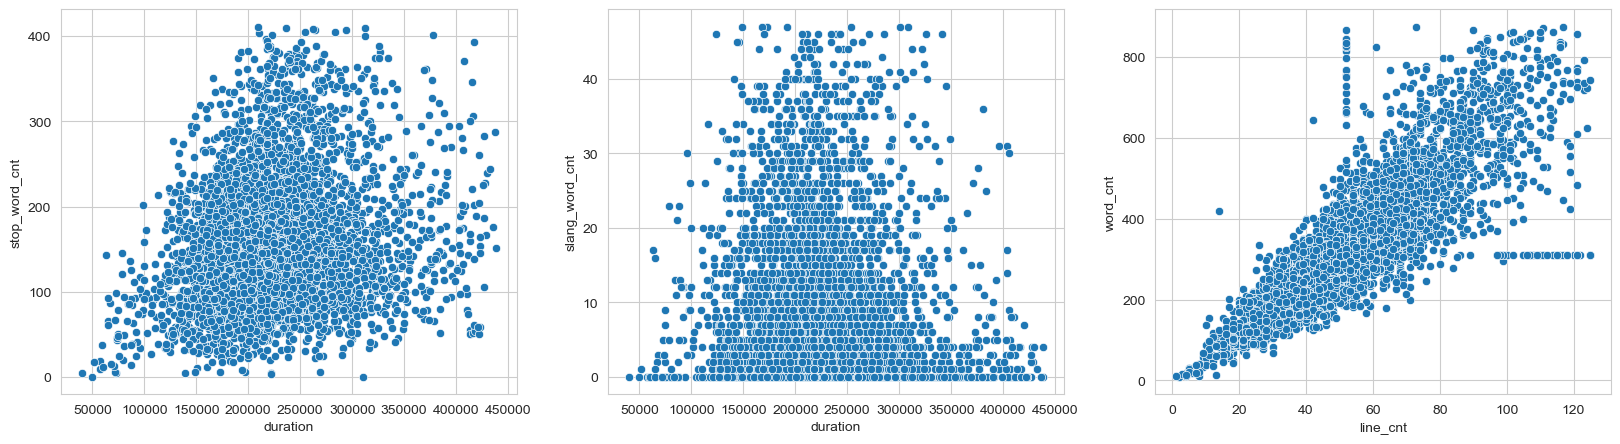

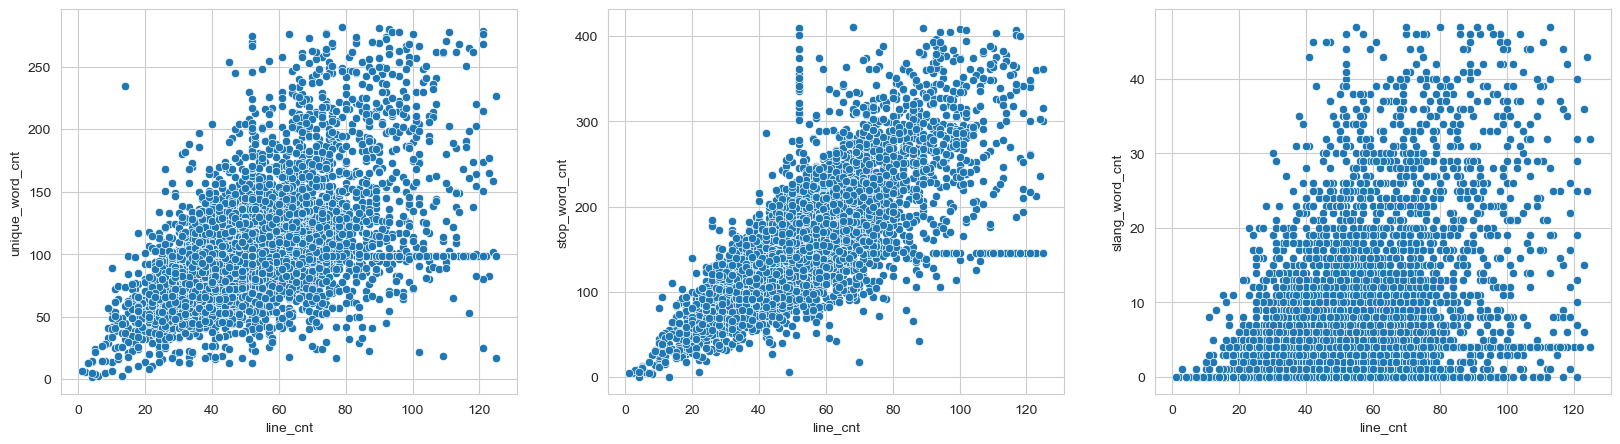

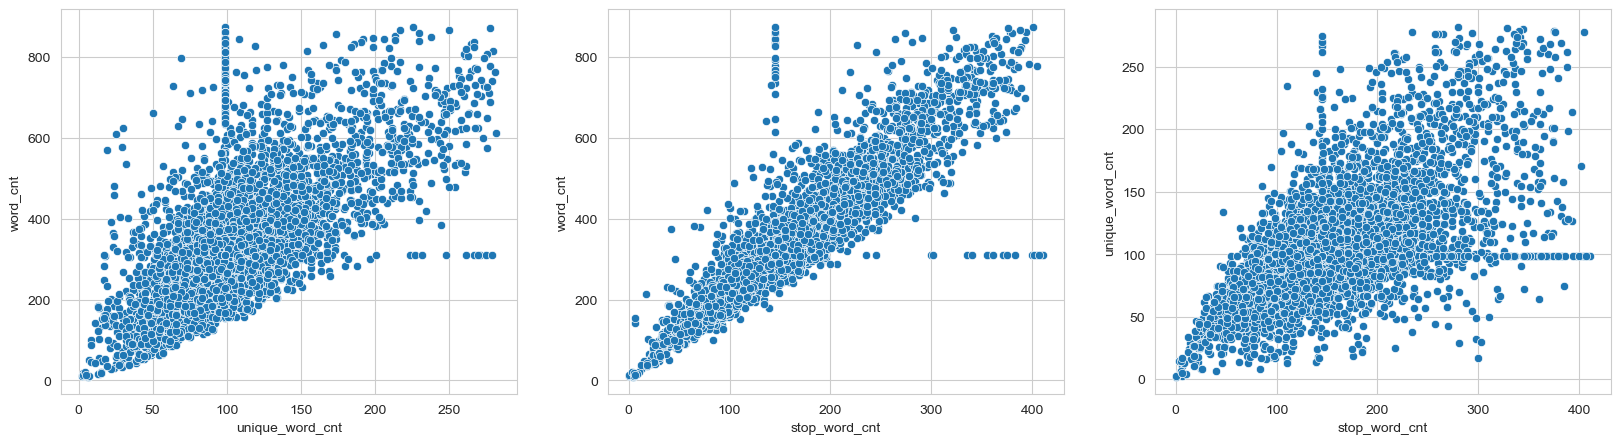

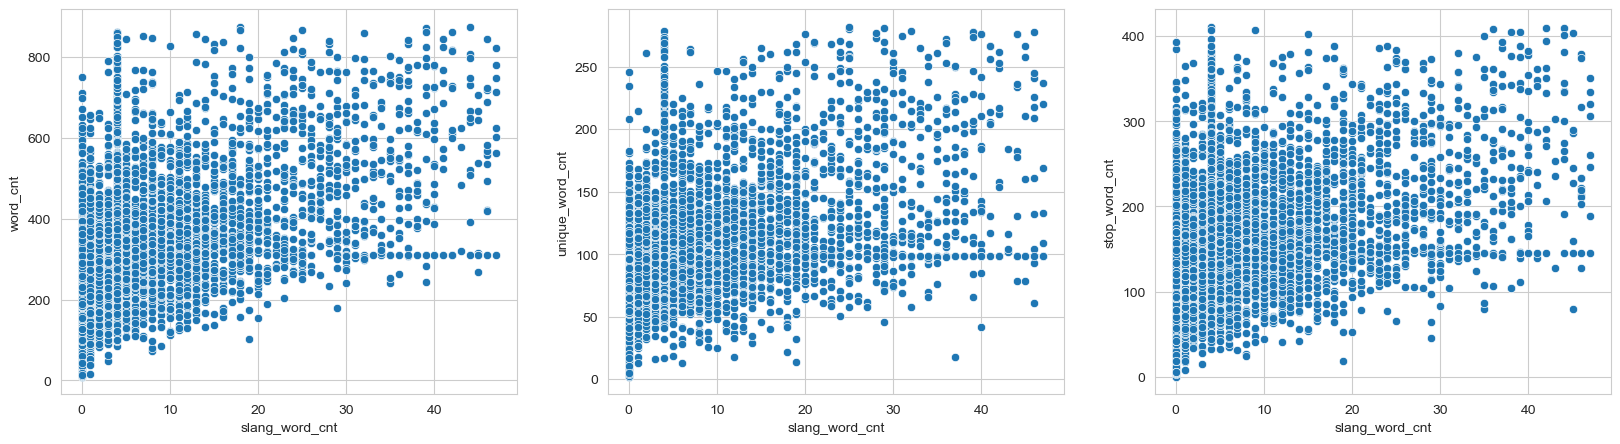

In [19]:
continuous_vars = ["duration", "line_cnt", "word_cnt", "unique_word_cnt", "stop_word_cnt", "slang_word_cnt"]
plot_continuous_feature_relations(repaired, continuous_vars)

## EDA

<Axes: >

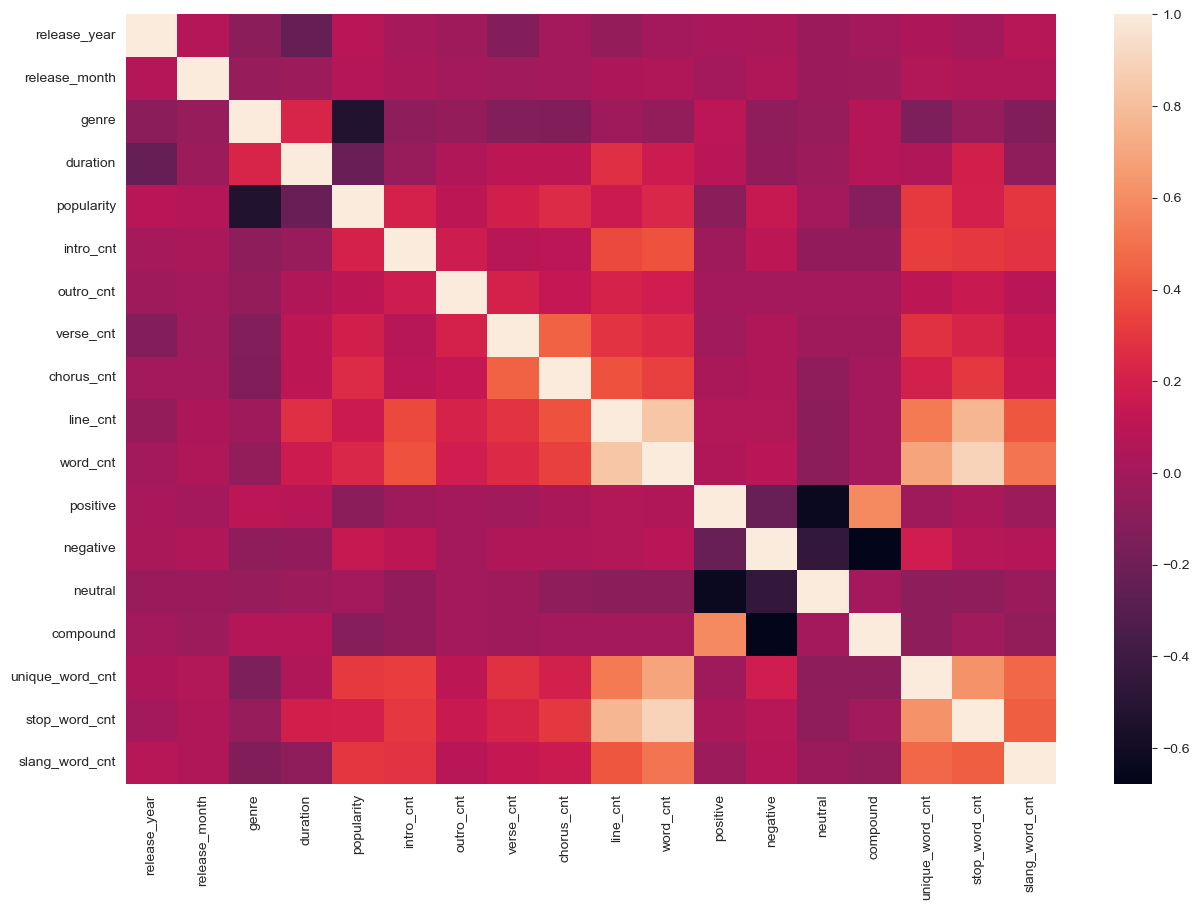

In [20]:
for_heat = repaired.copy()
for_heat.genre = pd.factorize(for_heat.genre)[0]
plt.figure(figsize=(15, 10))
sub_df = for_heat.select_dtypes('number')
sns.heatmap(sub_df.corr())

In [21]:
ratios = ["slang_word", "unique_word", "stop_word"]
repaired[[f"{field}_ratio" for field in ratios]] = repaired.apply(lambda x: x[[f"{field}_cnt" for field in ratios]]/x.word_cnt, axis=1)

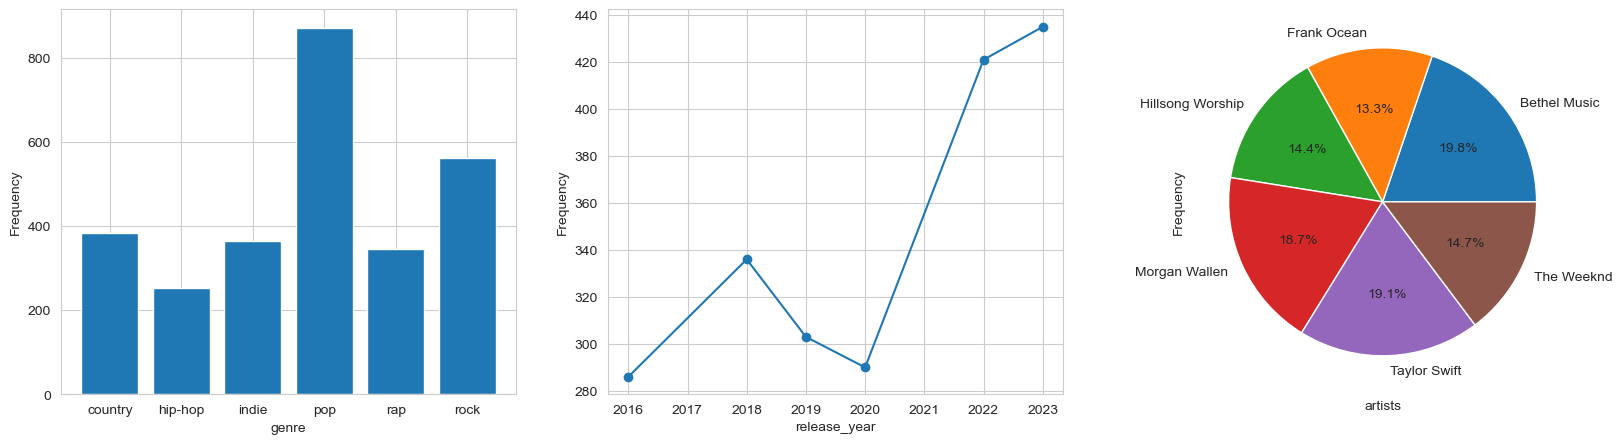

In [22]:
df_params = pd.DataFrame({'plot_type': ['bar', 'line', 'pie'],
                          'col_name': ['genre', 'release_year', 'artists'],
                          'num_top_elements': [6,6,6]})
plot_frequent_elements(repaired, df_params)

In [23]:
plt.rcParams["figure.figsize"] = (18,6)

In [24]:
cols_to_bin = ['release_year', 'duration', 'line_cnt', 'word_cnt', 'positive', 'negative', 'compound']
categorical_cols = ['chorus_cnt', 'verse_cnt', 'intro_cnt', 'outro_cnt']
transferred = transfer_to_categorical(repaired, cols_to_bin, categorical_cols)

## MACHINE LEARNING SECTION

In [25]:
transferred = transfer_str_to_numeric_vals(transferred)
transferred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5034 entries, 0 to 15397
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   source_genre              5034 non-null   int64   
 1   name                      5034 non-null   int64   
 2   artists                   5034 non-null   int64   
 3   release_year              5034 non-null   int64   
 4   release_month             5034 non-null   int64   
 5   genres                    5034 non-null   int64   
 6   genre                     5034 non-null   category
 7   duration                  5034 non-null   int64   
 8   popularity                5034 non-null   int64   
 9   lyrics_file               5034 non-null   int64   
 10  lyrics_url                5034 non-null   int64   
 11  line_cnt                  5034 non-null   int64   
 12  word_cnt                  5034 non-null   int64   
 13  positive                  5034 non-null   int64

In [26]:
# 'popularity', 'compound', 'neutral', 'line_cnt'
debug_cols = ['artists', 'genres', 'source_genre', 'name', 'lyrics_file', 'lyrics_url']
prepared = transferred.drop(columns=debug_cols, axis=1)

In [27]:
X_train, X_test, y_train, y_test = split_to_train_and_test(prepared, 'genre', 0.2, 5)
best_k, best_score = find_best_k_for_KNN(X_train, y_train)
print(best_k, best_score)

19 0.18873017585500054


In [28]:
params = {'n_neighbors':best_k}
knn_clf = get_classifier_obj("KNN",params)
knn_clf.fit(X_train, y_train)
y_predicted = knn_clf.predict(X_test)
accuracy_val = calc_evaluation_val("accuracy", y_test, y_predicted)
cm_val = calc_evaluation_val("confusion_matrix", y_test, y_predicted)
print(accuracy_val)
print(cm_val)

0.20556107249255212
[[ 0  0  5  0  0  0  0  0  0  2  3  0  2 19  0  1  2  0  3  1  0]
 [ 1  1  1  0  0  0  0  0  0  0  2  1  1  9  0  0  2  0  4  0  1]
 [ 3  0 34  0  0  0  0  0  0  1  3  0  0 19  0  0  2  0  6  0  1]
 [ 1  0  2  0  0  0  0  0  1  0  1  0  1 11  0  0  1  0  1  0  0]
 [ 0  1  2  0  0  1  0  0  1  0  1  0  1  4  0  1  0  0  2  2  1]
 [ 1  1  3  1  0  1  1  0  0  0  1  0  2  9  0  0  0  0  4  1  0]
 [ 1  1  4  0  0  0  1  0  1  0  6  0  0 12  0  0  0  0  3  0  0]
 [ 0  0  1  1  0  0  0  0  1  0  0  0  0  9  0  1  1  0  2  0  2]
 [ 0  0  4  0  0  0  0  0  1  1  0  0  0 10  0  1  0  0  4  0 16]
 [ 0  0 12  0  0  1  1  1  0  3  6  0  1 15  0  0  6  0  5  3  1]
 [ 0  2 14  0  0  0  5  0  1  2 13  0  1 23  0  1  3  0 12  0  2]
 [ 1  0  2  1  0  0  1  1  0  0  0  0  0  5  0  0  0  0  2  0  0]
 [ 0  1  5  0  0  0  0  0  0  0  5  0  5 18  0  0  0  0 11  1  2]
 [ 4  1 19  3  0  1  3  0  0  4 16  1  1 99  1  6  6  0 18  1  4]
 [ 1  2  5  0  0  0  0  0  1  2  3  0  1 10  0  1  1  0 

In [29]:
max_dep = 5
min_smpl_split = 3
best_clf, best_recall_val=find_best_model(X_train, y_train, max_dep, min_smpl_split)
print(best_clf,best_recall_val)

DecisionTreeClassifier(max_depth=5, min_samples_split=3) -1


In [30]:
best_clf.fit(X_train, y_train)
y_predicted = best_clf.predict(X_test)
accuracy_val = calc_evaluation_val("accuracy", y_test, y_predicted)
print(accuracy_val)

0.2442899702085402
